In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")
np.random.seed(42)

In [9]:
cities = [0, 1, 2, 3, 4]

adjacency_mat = np.asarray(
    [
        [0.00, 28.02, 17.12, 27.46, 46.07],
        [28.02, 0.00, 34.00, 25.55, 25.55],
        [17.12, 34.00, 0.00, 18.03, 57.38],
        [27.46, 25.55, 18.03, 0.00, 51.11],
        [46.07, 25.55, 57.38, 51.11, 0.00],
    ]
)

class Population():
    def __init__(self, bag, adjacency_mat):
        self.bag = bag
        self.parents = []
        self.score = 0
        self.best = None
        self.adjacency_mat = adjacency_mat

    def fitness(self, chromosome):
        return sum(
            [
                self.adjacency_mat[chromosome[i], chromosome[i + 1]]
                for i in range(len(chromosome) - 1)
            ]
        )

    def evaluate(self):
        distances = np.asarray(
            [self.fitness(chromosome) for chromosome in self.bag]
        )
        self.score = np.min(distances)
        self.best = self.bag[distances.tolist().index(self.score)]
        self.parents.append(self.best)
        if False in (distances[0] == distances): #if not all distances are equal (one is the worse one)
            distances = np.max(distances) - distances #distances are reversed (bigger is better) such the worst one is now value 0
        return distances / np.sum(distances)
    
    def select(self, k=4):
        fit = self.evaluate()
        while len(self.parents) < k:
            idx = np.random.randint(0, len(fit))
            if fit[idx] > np.random.rand():
                self.parents.append(self.bag[idx])
        self.parents = np.asarray(self.parents)

    def breed(self, n_population, p_breed=0.1): #crossover
        children = []
        count, size = self.parents.shape
        for _ in range(n_population):
            if np.random.rand() > p_breed:
                children.append(
                    list(self.parents[np.random.randint(count, size=1)[0]])
                )
            else:
                parent1, parent2 = self.parents[
                    np.random.randint(count, size=2), :
                ]
                idx = np.random.choice(range(size), size=2, replace=False)
                start, end = min(idx), max(idx)
                child = [None] * size
                for i in range(start, end + 1, 1):
                    child[i] = parent1[i]
                pointer = 0
                for i in range(size):
                    if child[i] is None:
                        while parent2[pointer] in child:
                            pointer += 1
                        child[i] = parent2[pointer]
                children.append(child)
        return children
    
    def mutate(self, children, p_mut=0.1):
        next_bag = []
        for child in children:
            if np.random.rand() < p_mut:
                next_bag.append(swap(child))
            else:
                next_bag.append(child)
        return next_bag

def swap(chromosome):
    a, b = np.random.choice(len(chromosome), 2)
    chromosome[a], chromosome[b] = (
        chromosome[b],
        chromosome[a],
    )
    return chromosome



def init_population(cities, adjacency_mat, n_population):
    return Population(
        np.asarray([np.random.permutation(cities) for _ in range(n_population)]), 
        adjacency_mat
    )

def genetic_algorithm(
    cities,
    adjacency_mat,
    n_population=5,
    n_iter=20,
    selectivity=0.15,
    p_breed=0.5,
    p_mut=0.1,
    print_interval=100,
    return_history=False,
    verbose=False,
):
    population = init_population(cities, adjacency_mat, n_population)
    best = population.best
    score = float("inf")
    history = []
    for i in range(n_iter):
        population.select(n_population * selectivity)
        history.append(population.score)
        if verbose:
            print(f"Generation {i}: {population.score}")
        elif i % print_interval == 0:
            print(f"Generation {i}: {population.score}")
        if population.score < score:
            best = population.best
            score = population.score
        children = population.breed(n_population, p_breed)
        children_mutated = population.mutate(children, p_mut)
        population = Population(children_mutated, population.adjacency_mat)
    if return_history:
        return best, history
    return best



In [12]:
genetic_algorithm(cities, adjacency_mat, verbose=True)

Generation 0: 86.25
Generation 1: 86.25
Generation 2: 86.25
Generation 3: 86.25
Generation 4: 86.25
Generation 5: 86.25
Generation 6: 86.25
Generation 7: 86.25
Generation 8: 86.25
Generation 9: 86.25
Generation 10: 86.25
Generation 11: 86.25
Generation 12: 86.25
Generation 13: 86.25
Generation 14: 86.25
Generation 15: 86.25
Generation 16: 86.25
Generation 17: 86.25
Generation 18: 86.25
Generation 19: 86.25


array([4, 1, 3, 2, 0])

In [7]:
def generate_cities(n_cities, factor=10):
    return np.random.rand(n_cities, 2) * n_cities * factor


def make_mat(coordinates):
    res = [
        [get_distance(city1, city2) for city2 in coordinates]
        for city1 in coordinates
    ]
    return np.asarray(res)

def get_distance(city1, city2):
    return np.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)


Generation 0: 45855.37066110952
Generation 100: 34824.74834298915
Generation 200: 29325.595356854516
Generation 300: 26746.958304640855
Generation 400: 25653.580516778857
Generation 500: 24781.34987883584
Generation 600: 23300.43285804417
Generation 700: 22092.054527140615
Generation 800: 21625.74467497873
Generation 900: 21214.229665903247


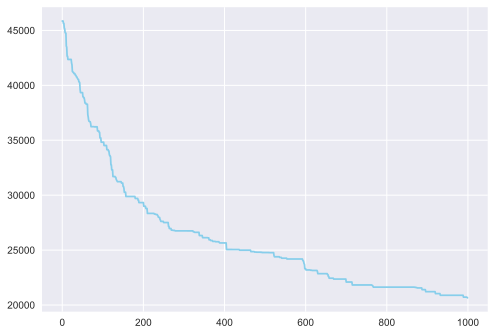

[28, 54, 25, 9, 45, 49, 35, 22, 76, 93, 29, 52, 18, 91, 59, 40, 98, 46, 8, 88, 4, 11, 23, 10, 64, 69, 42, 74, 79, 89, 36, 61, 39, 71, 99, 83, 60, 13, 90, 63, 62, 15, 26, 37, 44, 68, 6, 67, 56, 43, 85, 34, 48, 84, 97, 47, 33, 16, 17, 65, 20, 70, 87, 66, 53, 7, 5, 58, 73, 94, 41, 75, 82, 0, 21, 27, 55, 92, 12, 38, 14, 72, 78, 77, 96, 31, 80, 81, 57, 1, 3, 30, 2, 86, 24, 50, 19, 51, 95, 32]


In [8]:
cities = range(100)
city_coordinates = generate_cities(len(cities))
adjacency_mat = make_mat(city_coordinates)
best, history = genetic_algorithm(
    cities, adjacency_mat, n_population=20, n_iter=1000, verbose=False, return_history=True
)
plt.plot(range(len(history)), history, color="skyblue")
plt.show()
print(best)
